# Project: Model for determining the temperature of steel.

The condition of the task of increasing the volume of production costs, the metallurgical plant "Temper Steel" decided to reduce the consumption of electricity for steel processing. You have to build a steel model that will predict the temperature.

Description of processing processes.
Steel processing in a metal ladle with a capacity of about 100 tons. In order for the ladle to withstand high temperatures, it is covered with refractory bricks from the inside. Molten steel is poured into the boiler and heated to the required temperature with graphite electrodes. They are installed in the lid of the bucket.

Sulfur is removed from the alloy (desulfurization), the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire through a special tribe apparatus.

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.


Then the molten steel is sent to finish the metal or enters the continuous casting machine. From there, the finished product comes out in the form of slab blanks (English slab, “slab”).

Data Description
The data consists of files obtained from various sources:

* data_arc.csv — electrode data;
* data_bulk.csv — bulk material feed data (volume);
* data_bulk_time.csv — bulk material feed data (time);
* data_gas.csv — alloy gas purge data;
* data_temp.csv — temperature measurement results;
* data_wire.csv — wire materials data (volume);
* data_wire_time.csv — wire material data (time).

In [1]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functools as ft

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

In [2]:
electrods = pd.read_csv('C:/fails_for_pyton/final_steel/data_arc.csv')
bulk_materials_volume = pd.read_csv('C:/fails_for_pyton/final_steel/data_bulk.csv')
bulk_materials_time = pd.read_csv('C:/fails_for_pyton/final_steel/data_bulk_time.csv')
expultion_gas = pd.read_csv('C:/fails_for_pyton/final_steel/data_gas.csv')
temperature = pd.read_csv('C:/fails_for_pyton/final_steel/data_temp.csv')
wire_materials_volume = pd.read_csv('C:/fails_for_pyton/final_steel/data_wire.csv')
wire_materials_time = pd.read_csv('C:/fails_for_pyton/final_steel/data_wire_time.csv')

# 1. Data analysis and preprocessing

## 1.1. Analysis and processing of electrode data

In [3]:
# output of general information on electrodes and the first 10 rows of the table
electrods = electrods.rename(columns={'Начало нагрева дугой': 'start_of_arc_heating',
                                     'Конец нагрева дугой': 'end_of_arc_heating',
                                     'Активная мощность': 'active_power',
                                     'Реактивная мощность': 'reactive_power'})
electrods.info()
display(electrods.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   start_of_arc_heating  14876 non-null  object 
 2   end_of_arc_heating    14876 non-null  object 
 3   active_power          14876 non-null  float64
 4   reactive_power        14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


There are no gaps in the columns, check for anomalies


We derive general statistical information, construct histograms and a box with a mustache for a column with active power.

In [4]:
electrods['active_power'].describe()

count    14876.000000
mean         0.670441
std          0.408159
min          0.030002
25%          0.395297
50%          0.555517
75%          0.857034
max          3.731596
Name: active_power, dtype: float64

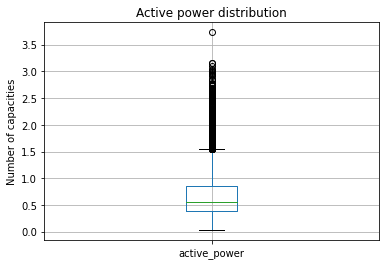

In [5]:
electrods.boxplot('active_power')
plt.title('Active power distribution')
plt.ylabel('Number of capacities')
plt.show()

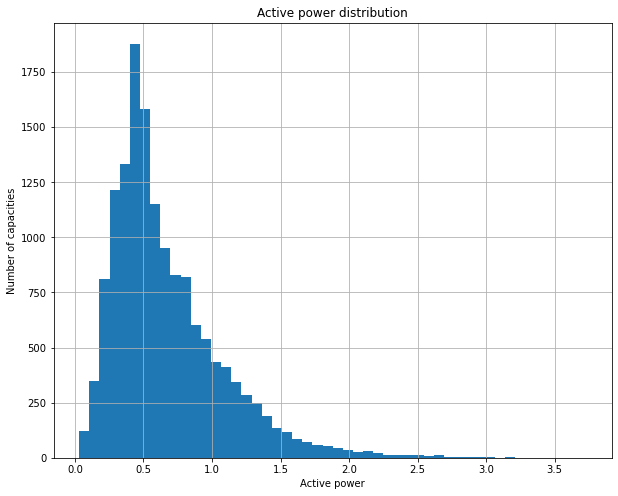

In [6]:
electrods['active_power'].hist(bins=50, figsize=(10,8))
plt.title('Active power distribution')
plt.xlabel('Active power')
plt.ylabel('Number of capacities')
plt.show()

Conclusion: the average value of active power is greater than the median value. On the histogram and the box with a mustache we have outliers above 1.5, but such values may exist in reality. These values should be left other the model may turn out to be too optimistic.

We derive general statistical information, construct histograms and a box with a mustache for a column with reactive power.

In [7]:
electrods['reactive_power'].describe()

count    14876.000000
mean         0.452592
std          5.878702
min       -715.504924
25%          0.290991
50%          0.415962
75%          0.637371
max          2.676388
Name: reactive_power, dtype: float64

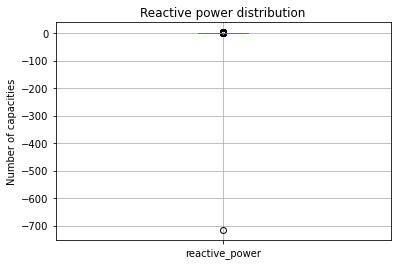

In [8]:
electrods.boxplot('reactive_power')
plt.title('Reactive power distribution')
plt.ylabel('Number of capacities')
plt.show()

There is one large negative anomalous value. It should be removed.


In [9]:
print(electrods[electrods['reactive_power'] > 0]['reactive_power'].describe())

count    14875.000000
mean         0.500723
std          0.310880
min          0.020806
25%          0.291003
50%          0.415984
75%          0.637403
max          2.676388
Name: reactive_power, dtype: float64


<AxesSubplot:>

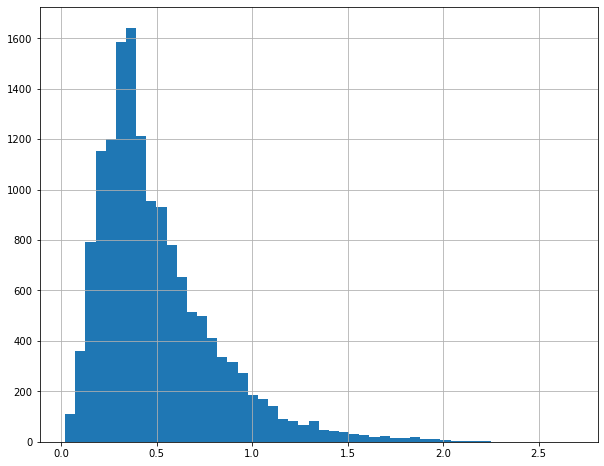

In [10]:
electrods[electrods['reactive_power'] > 0]['reactive_power'].hist(bins=50, figsize=(10,8))

In [11]:
# Let's find the correlation between powers
print(electrods['active_power'].corr(electrods[electrods['reactive_power'] > 0]['reactive_power']))

0.9631819131519802


Conclusion: The correlations between powers are very good.


In [12]:
# Find the number of unique keys
len(electrods['key'].unique())

3214

## 1.2. Analysis and processing of data on the supply of bulk materials

In [13]:
# output of general information on electrodes and the first 10 rows of the table
bulk_materials_volume.info()
display(bulk_materials_volume.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Bulk 1


count    252.000000
mean      39.242063
std       18.277654
min       10.000000
25%       27.000000
50%       31.000000
75%       46.000000
max      185.000000
Name: Bulk 1, dtype: float64

Bulk 2


count     22.000000
mean     253.045455
std       21.180578
min      228.000000
25%      242.000000
50%      251.500000
75%      257.750000
max      325.000000
Name: Bulk 2, dtype: float64

Bulk 3


count    1298.000000
mean      113.879045
std        75.483494
min         6.000000
25%        58.000000
50%        97.500000
75%       152.000000
max       454.000000
Name: Bulk 3, dtype: float64

Bulk 4


count    1014.000000
mean      104.394477
std        48.184126
min        12.000000
25%        72.000000
50%       102.000000
75%       133.000000
max       281.000000
Name: Bulk 4, dtype: float64

Bulk 5


count     77.000000
mean     107.025974
std       81.790646
min       11.000000
25%       70.000000
50%       86.000000
75%      132.000000
max      603.000000
Name: Bulk 5, dtype: float64

Bulk 6


count    576.000000
mean     118.925347
std       72.057776
min       17.000000
25%       69.750000
50%      100.000000
75%      157.000000
max      503.000000
Name: Bulk 6, dtype: float64

Bulk 7


count     25.000000
mean     305.600000
std      191.022904
min       47.000000
25%      155.000000
50%      298.000000
75%      406.000000
max      772.000000
Name: Bulk 7, dtype: float64

Bulk 8


count     1.0
mean     49.0
std       NaN
min      49.0
25%      49.0
50%      49.0
75%      49.0
max      49.0
Name: Bulk 8, dtype: float64

Bulk 9


count     19.000000
mean      76.315789
std       21.720581
min       63.000000
25%       66.000000
50%       68.000000
75%       70.500000
max      147.000000
Name: Bulk 9, dtype: float64

Bulk 10


count    176.000000
mean      83.284091
std       26.060347
min       24.000000
25%       64.000000
50%       86.500000
75%      102.000000
max      159.000000
Name: Bulk 10, dtype: float64

Bulk 11


count    177.000000
mean      76.819209
std       59.655365
min        8.000000
25%       25.000000
50%       64.000000
75%      106.000000
max      313.000000
Name: Bulk 11, dtype: float64

Bulk 12


count    2450.000000
mean      260.471020
std       120.649269
min        53.000000
25%       204.000000
50%       208.000000
75%       316.000000
max      1849.000000
Name: Bulk 12, dtype: float64

Bulk 13


count     18.000000
mean     181.111111
std       46.088009
min      151.000000
25%      153.250000
50%      155.500000
75%      203.500000
max      305.000000
Name: Bulk 13, dtype: float64

Bulk 14


count    2806.000000
mean      170.284747
std        65.868652
min        16.000000
25%       119.000000
50%       151.000000
75%       205.750000
max       636.000000
Name: Bulk 14, dtype: float64

Bulk 15


count    2248.000000
mean      160.513345
std        51.765319
min         1.000000
25%       105.000000
50%       160.000000
75%       205.000000
max       405.000000
Name: Bulk 15, dtype: float64

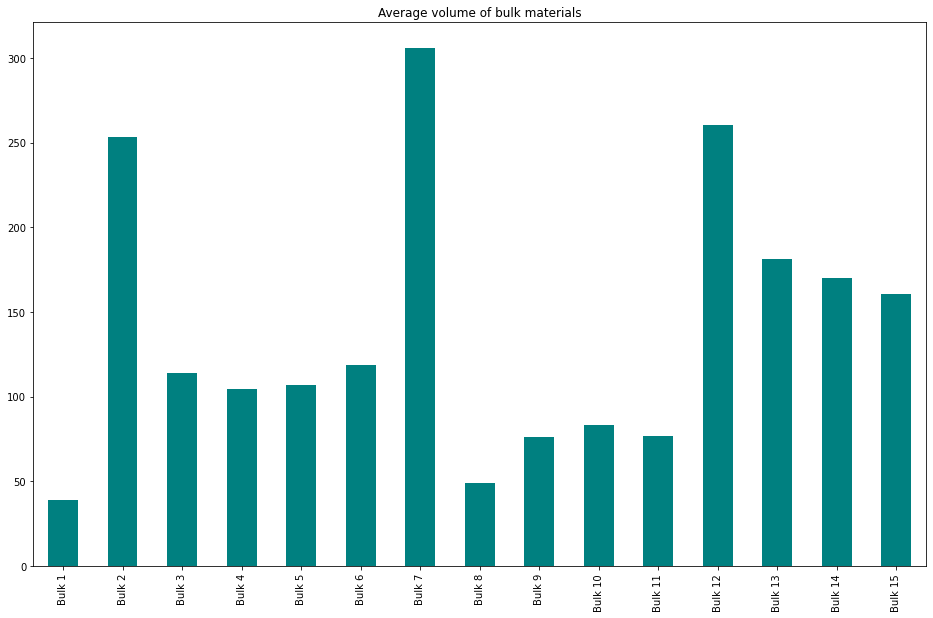

In [14]:
# We derive general statistical information for each column with the volume of bulk materials
# and a histogram of the average value of the volumes of bulk materials

a = bulk_materials_volume.drop('key', axis=1)

for column in a.columns:
    print(column)
    display(a[column].describe())
    plt.title('Average volume of bulk materials')
    a.mean().plot.bar(x = column, figsize=(16,10), color = 'teal')
    


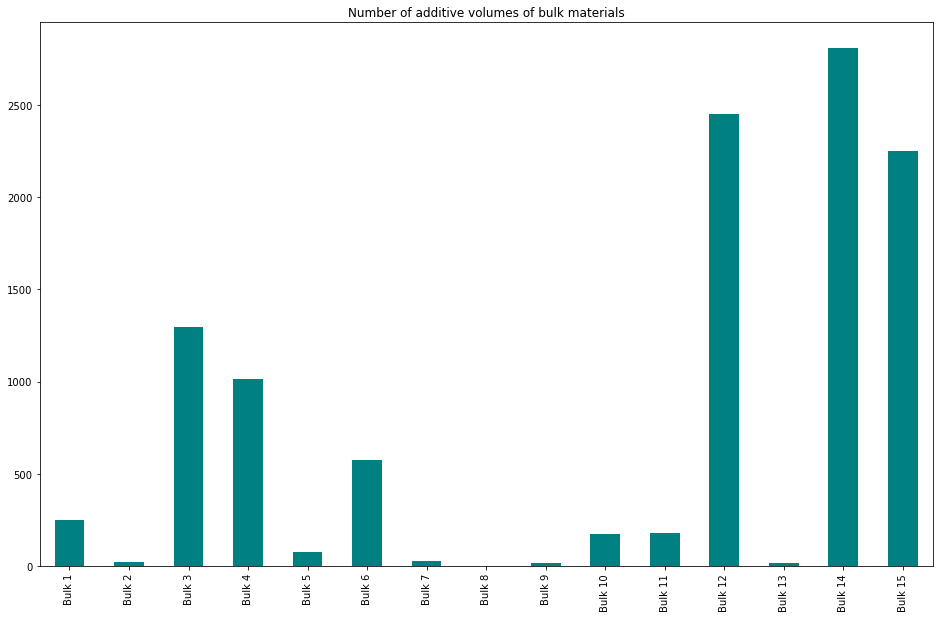

In [15]:
# We derive a histogram of the number of additives of volumes of bulk materials
for column in a.columns:
    plt.title('Number of additive volumes of bulk materials')
    a.count().plot.bar(x = column, figsize=(16,10), color = 'teal')

The main volume of supply of additive bulk materials in 3, 4, 12, 14 and 15 volumes. The smallest amount of additives fed in 2, 5, 7, 8, 9 and 13 volumes. Missing values indicate the absence of an additive in the lot. We cannot compare the values of the volumes of each additive and consider anything as an outlier. This may affect the quality of the model.
Number of keys 3129.

## 1.3. Analysis and processing of data on the time of supply of bulk materials

In [16]:
# output of general information on electrodes and the first 10 rows of the table
bulk_materials_time.info()
display(bulk_materials_time.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
5,6,NaN,NaN,NaN,2019-05-03 13:59:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:53:27,NaN,2019-05-03 13:53:27,2019-05-03 13:53:27
6,7,NaN,NaN,NaN,2019-05-03 14:29:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:22:19,NaN,2019-05-03 14:22:19,2019-05-03 14:22:19
7,8,NaN,NaN,NaN,2019-05-03 15:04:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:55:46,NaN,2019-05-03 14:55:46,2019-05-03 14:55:46
8,9,NaN,NaN,NaN,2019-05-03 15:47:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:41:00,NaN,2019-05-03 15:41:00,2019-05-03 15:41:00
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:18:52,NaN,2019-05-03 16:18:52,2019-05-03 16:18:52


Conclusion: There is a relationship between the bulk_materials_volume and bulk_materials_time tables in terms of the number of lots and volumes. The delivery time of volumes 12,14,15 coincides, which means that these additives were added at the same time. Number of parties 3129.

## 1.4. Analysis and processing of data on gas blowing of the alloy

In [17]:
# output of general information on electrodes and the first 10 rows of the table
expultion_gas = expultion_gas.set_axis(['key', 'gas'], axis='columns', inplace=False)
expultion_gas.info()
display(expultion_gas.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


We derive general statistical information, build histograms and a box with a mustache for a column with gas volume.

In [18]:
expultion_gas['gas'].describe()

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: gas, dtype: float64

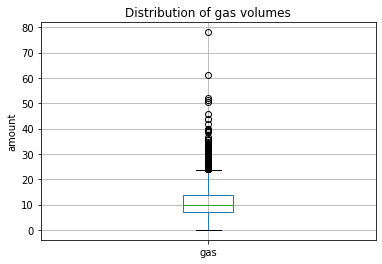

In [19]:
expultion_gas.boxplot('gas')
plt.title('Distribution of gas volumes')
plt.ylabel('amount')
plt.show()

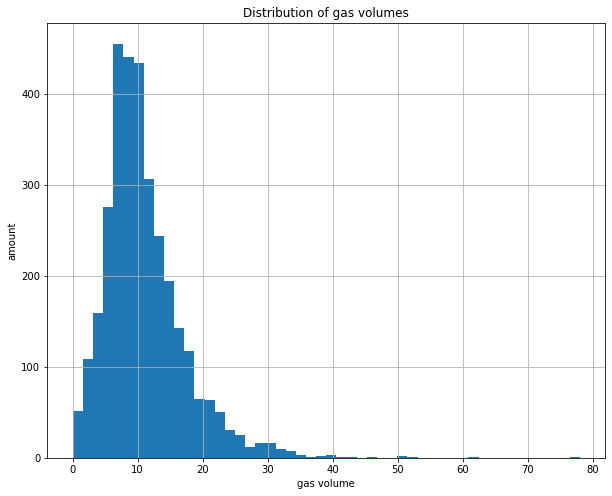

In [20]:
expultion_gas['gas'].hist(bins=50, figsize=(10,8))
plt.title('Distribution of gas volumes')
plt.xlabel('gas volume')
plt.ylabel('amount')
plt.show()

Conclusion: Values greater than 25 may be outliers. In order not to worsen the model, we will leave them unchanged.

## 1.5. Analysis of temperature measurements

In [21]:
# output of general information on electrodes and the first 10 rows of the table
temperature = temperature.set_axis(['key', 'time', 'temperature'], axis='columns', inplace=False)
temperature.info()
display(temperature.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   time         15907 non-null  object 
 2   temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


Let's display general statistical information, build histograms and a box with a mustache for a column with temperature.

In [22]:
temperature['temperature'].describe()

count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: temperature, dtype: float64

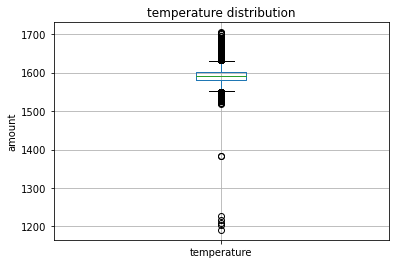

In [23]:
temperature.boxplot('temperature')
plt.title('temperature distribution')
plt.ylabel('amount')
plt.show()

In [24]:
# Number of unique keys
len(temperature['key'].unique())

3216

Conlusion: There are no outliers of values ​​as such, but there are temperature values ​​below the passport one (1400), which can be considered an outlier.

## 1.6. Wire material analysis

In [25]:
# output of general information on electrodes and the first 10 rows of the table
wire_materials_volume.info()
display(wire_materials_volume.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Wire 1


count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

Wire 2


count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64

Wire 3


count     63.000000
mean     189.482681
std       99.513444
min        0.144144
25%       95.135044
50%      235.194977
75%      276.252014
max      385.008668
Name: Wire 3, dtype: float64

Wire 4


count     14.000000
mean      57.442842
std       28.824667
min       24.148801
25%       40.807002
50%       45.234282
75%       76.124619
max      113.231044
Name: Wire 4, dtype: float64

Wire 5


count     1.000
mean     15.132
std         NaN
min      15.132
25%      15.132
50%      15.132
75%      15.132
max      15.132
Name: Wire 5, dtype: float64

Wire 6


count     73.000000
mean      48.016974
std       33.919845
min        0.034320
25%       25.053600
50%       42.076324
75%       64.212723
max      180.454575
Name: Wire 6, dtype: float64

Wire 7


count    11.000000
mean     10.039007
std       8.610584
min       0.234208
25%       6.762756
50%       9.017009
75%      11.886057
max      32.847674
Name: Wire 7, dtype: float64

Wire 8


count     19.000000
mean      53.625193
std       16.881728
min       45.076721
25%       46.094879
50%       46.279999
75%       48.089603
max      102.762401
Name: Wire 8, dtype: float64

Wire 9


count    29.000000
mean     34.155752
std      19.931616
min       4.622800
25%      22.058401
50%      30.066399
75%      43.862003
max      90.053604
Name: Wire 9, dtype: float64

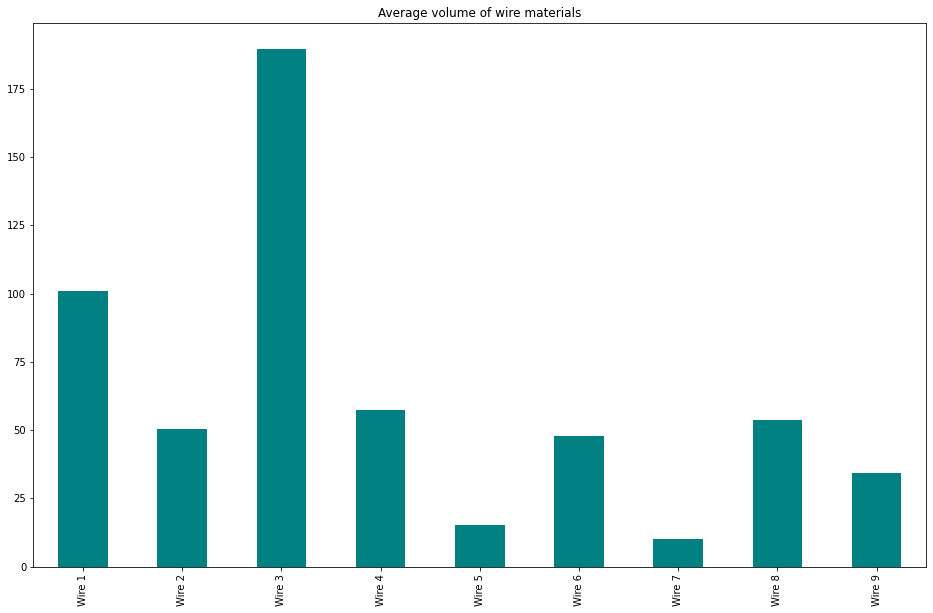

In [26]:
# We derive general statistical information for each column with the volume of wire materials
b = wire_materials_volume.drop('key', axis=1)

for column in b.columns:
    print(column)
    display(b[column].describe())
    plt.title('Average volume of wire materials')
    b.mean().plot.bar(x = column, figsize=(16,10), color = 'teal')

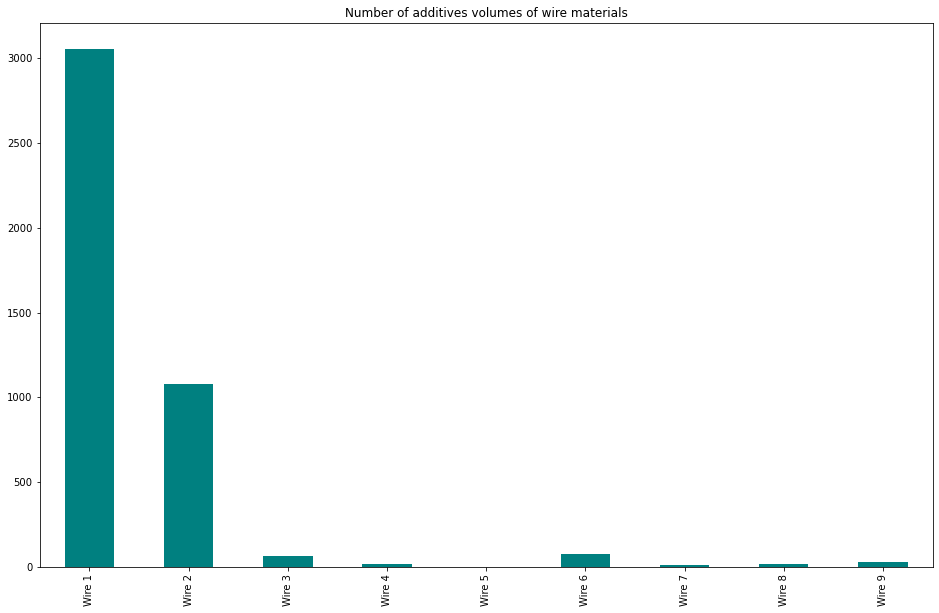

In [27]:
for column in b.columns:
    plt.title('Number of additives volumes of wire materials')
    b.count().plot.bar(x = column, figsize=(16,10), color = 'teal')

Conclusion: there are 3081 parties in this table. The main volumes are added in the first and second wire volumes. It is difficult to say anything about the distribution of values; for a qualitative solution of the problem, it is better to leave these values.

## 1.7. Time analysis of wire materials

In [28]:
# output of general information on electrodes and the first 10 rows of the table
wire_materials_time.info()
display(wire_materials_time.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:59:02,2019-05-03 13:59:54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:28:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:03:42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:42:43,2019-05-03 15:58:12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:20:25,2019-05-03 16:21:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Conclusion: it can be seen from the time that the additives are added gradually and by the number of values ​​the table corresponds to wire_materials_volume.

## 1.8. General conclusion on the analysis

The analysis identified the following anomalies and issues:
* Abnormal value of reactive power should be removed
* It is worth deleting temperatures below the passport (1400)
* The gaps in the temperature table should also be removed
* The data type of some columns should be changed from float to int
* The tables have a different number of key columns, some of the data could be lost during preparation
* Time needs to be converted to datetime format

Model building plan:
* Preprocessing of detected anomalies and omissions.
* Combining attributes by key column, target attribute - final temperature, main attributes - active and reactive power, bulk materials and wire volumes, process start temperature, gas volume, electrode heating time. The time of adding bulk materials and wire should be neglected, since the data are not entirely correct for this task, the time of adding additives may be earlier than the time of measuring the first temperature.
* Run a multicollinearity check 
* Separation of features into training and test sets in a ratio of 4:1. 
* Training different models with hyperparameter fitting and cross-validation with MAE metric.
* Checking the best model on a test set.

# 2. Data preprocessing and preparation

## 2.1. Electrods table data preprocessing

In [29]:
# get rid of the anomalous value in the reactive power column
electrods = electrods.query('reactive_power > 0')

display(electrods.head(10))
electrods.describe()

,key,start_of_arc_heating,end_of_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


,key,active_power,reactive_power
count,14875.000000,14875.000000,14875.000000
mean,1615.186756,0.670453,0.500723
std,934.593897,0.408170,0.310880
min,1.000000,0.030002,0.020806
25%,806.000000,0.395295,0.291003
50%,1617.000000,0.555565,0.415984
75%,2429.000000,0.857049,0.637403
max,3241.000000,3.731596,2.676388


Let's sum the power values ​​for each switch to get all active and reactive power for each batch.

In [30]:
# Get a summary table of sums of active and reactive power values for each key
itog = electrods.pivot_table( index=['key'],values = ['active_power', 'reactive_power'], aggfunc='sum')
display(itog.head())

,active_power,reactive_power
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643


## 2.2. Temperature table data preprocessing

Delete all rows with missing values ​​and temperature less than 1400

In [31]:
# Removing gaps and values below the minimum allowable temperature
temperature = temperature.fillna(0)
temperature = temperature.query('temperature > 1400')

temperature.info()
display(temperature.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          12999 non-null  int64  
 1   time         12999 non-null  object 
 2   temperature  12999 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 406.2+ KB


,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


Let's create a summary table with the maximum and minimum temperature measurement time for each batch

In [32]:
temperature_mx = pd.pivot_table(temperature,
                                values='time',
                                index='key',
                                aggfunc={'time': [np.min, np.max]})
display(temperature_mx)

,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19
...,...,...
3237,2019-08-31 22:44:04,2019-08-31 22:44:04
3238,2019-08-31 23:30:31,2019-08-31 23:30:31
3239,2019-09-01 01:31:47,2019-09-01 01:31:47


Let's delete those batches where the measurements of the maximum and minimum temperature measurements are the same.

In [33]:
temperature_mx = temperature_mx.query('amax!=amin')
temperature_mx.info()
display(temperature_mx.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   amax    2475 non-null   object
 1   amin    2475 non-null   object
dtypes: object(2)
memory usage: 58.0+ KB


,amax,amin
key,,
1,2019-05-03 11:30:39,2019-05-03 11:16:18
2,2019-05-03 11:59:12,2019-05-03 11:37:27
3,2019-05-03 12:34:57,2019-05-03 12:13:17
4,2019-05-03 12:59:25,2019-05-03 12:52:57
5,2019-05-03 13:36:01,2019-05-03 13:23:19


We collect measurements of the initial and final temperatures.

In [34]:
# Let's make cuts by temperature values
min_time = list(temperature_mx['amin'])
max_time = list(temperature_mx['amax'])
min_time_temperature = temperature.query('time in @min_time')
min_time_temperature = min_time_temperature.set_index('key')
max_time_temperature = temperature.query('time in @max_time')
max_time_temperature = max_time_temperature.set_index('key')

# Let's join the necessary tables and leave only the initial and final temperatures
final_temperature = temperature_mx.join(min_time_temperature, on = 'key')
final_temperature = final_temperature.merge(max_time_temperature, on = 'key', how='left')
final_temperature = final_temperature.drop(columns=['amax', 'amin', 'time_x', 'time_y'], axis=1)
final_temperature = final_temperature.set_axis(['start_temperature', 'final_temperature'], axis='columns', inplace=False)
display(final_temperature)
final_temperature.info()

,start_temperature,final_temperature
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 1 to 2499
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   start_temperature  2475 non-null   float64
 1   final_temperature  2475 non-null   float64
dtypes: float64(2)
memory usage: 58.0 KB


## 2.3. Combining the Remaining Features

Combine the remaining features of the bulk_materials_volume, expulsion_gas, wire_materials_volume tables into the final table.

In [35]:
# Take out the indexes of the key column
bulk_materials_volume = bulk_materials_volume.set_index('key')
bulk_materials_volume.columns = [f'bulk_{x}' for x in range(1,16)]
expultion_gas= expultion_gas.set_index('key')
wire_materials_volume = wire_materials_volume.set_index('key')
wire_materials_volume.columns = [f'wire_{x}' for x in range(1,10)]

In [36]:
# join all tables
df = [itog, final_temperature, bulk_materials_volume, expultion_gas, wire_materials_volume]
final = ft.reduce(lambda left, right: pd.merge(left, right, on='key'), df)
# Replace missing values with zeros
final = final.fillna(0)

In [37]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       2329 non-null   float64
 1   reactive_power     2329 non-null   float64
 2   start_temperature  2329 non-null   float64
 3   final_temperature  2329 non-null   float64
 4   bulk_1             2329 non-null   float64
 5   bulk_2             2329 non-null   float64
 6   bulk_3             2329 non-null   float64
 7   bulk_4             2329 non-null   float64
 8   bulk_5             2329 non-null   float64
 9   bulk_6             2329 non-null   float64
 10  bulk_7             2329 non-null   float64
 11  bulk_8             2329 non-null   float64
 12  bulk_9             2329 non-null   float64
 13  bulk_10            2329 non-null   float64
 14  bulk_11            2329 non-null   float64
 15  bulk_12            2329 non-null   float64
 16  bulk_13            2329 

2329 batches left in processing

## 2.4. Replacing Data Types

Let's cast the columns with the volume of bulk materials and temperature to the int type, since they contain integer values.

In [38]:
final['final_temperature'] = final['final_temperature'].astype('int')
final['start_temperature'] = final['start_temperature'].astype('int')

 
for i in range(1,16):
    final[[f'bulk_{i}']] = final[[f'bulk_{i}']].astype('int')

final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       2329 non-null   float64
 1   reactive_power     2329 non-null   float64
 2   start_temperature  2329 non-null   int32  
 3   final_temperature  2329 non-null   int32  
 4   bulk_1             2329 non-null   int32  
 5   bulk_2             2329 non-null   int32  
 6   bulk_3             2329 non-null   int32  
 7   bulk_4             2329 non-null   int32  
 8   bulk_5             2329 non-null   int32  
 9   bulk_6             2329 non-null   int32  
 10  bulk_7             2329 non-null   int32  
 11  bulk_8             2329 non-null   int32  
 12  bulk_9             2329 non-null   int32  
 13  bulk_10            2329 non-null   int32  
 14  bulk_11            2329 non-null   int32  
 15  bulk_12            2329 non-null   int32  
 16  bulk_13            2329 

## 2.5. Multicollinearity estimation 

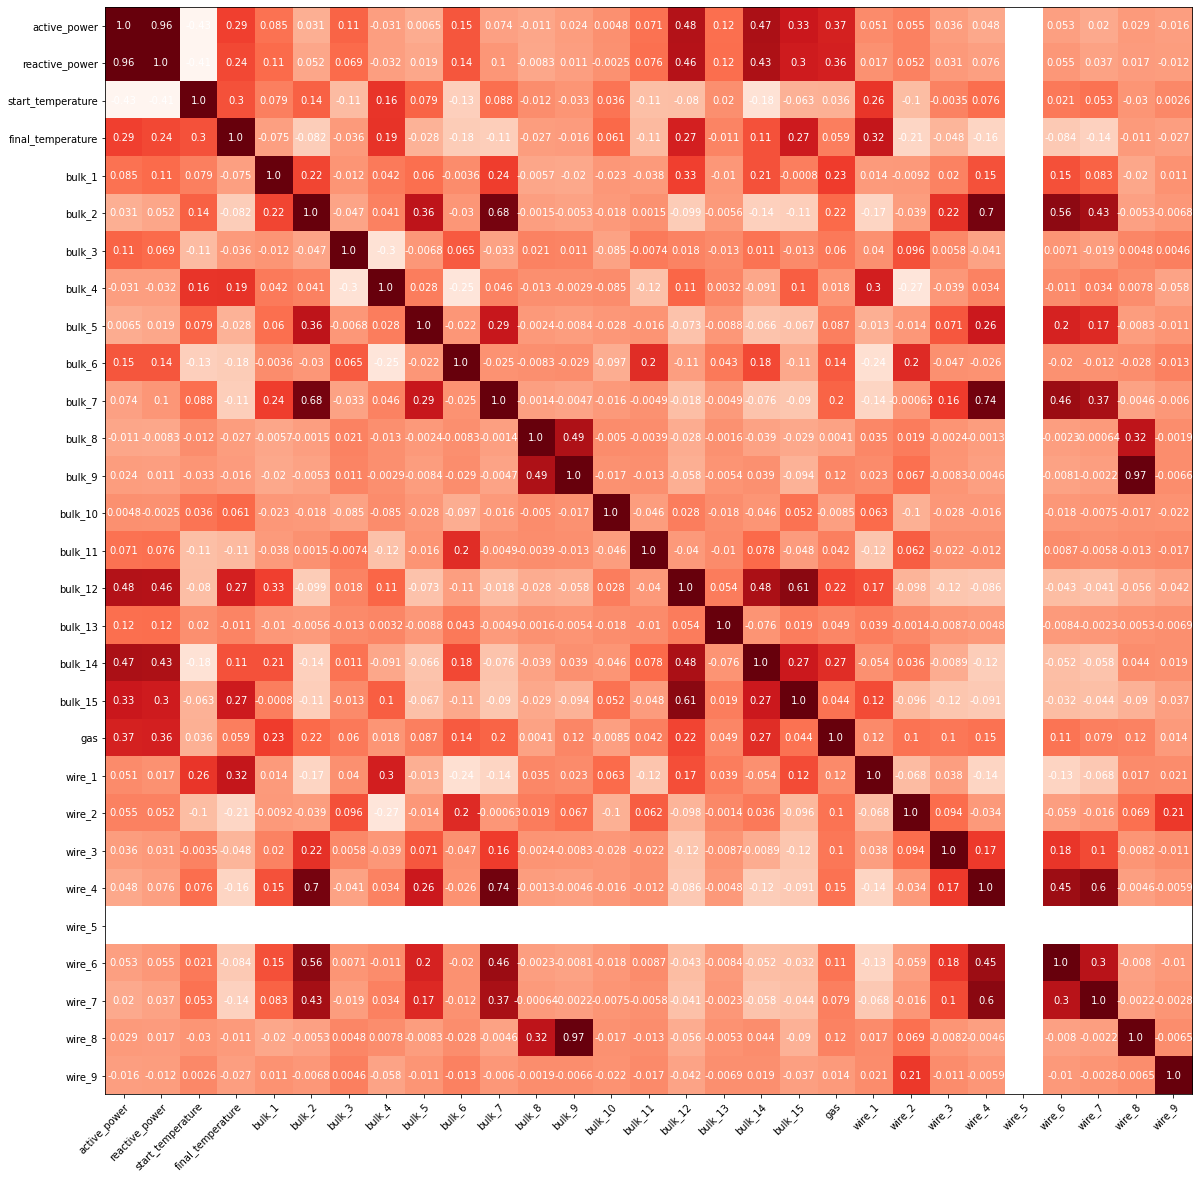

In [39]:
final_knn = final.copy()
corr_heatmap_final = final_knn.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(corr_heatmap_final.index)))
ax.set_yticks(np.arange(len(corr_heatmap_final.index)))

ax.set_xticklabels(corr_heatmap_final.index)
ax.set_yticklabels(corr_heatmap_final.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = corr_heatmap_final.values

for i in range(len(corr_heatmap_final.index)):
    for j in range(len(corr_heatmap_final.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(corr_heatmap_final.corr(), cmap='Reds')

Conclusion: when building a heatmap, it is clear that the wire_5 feature is without data. It should be removed. Very high correlation between active and reactive power and between bulk_9 and wire_8 (>0.9). So these feauters are interchangeable, we can remove one from each pair.

In [40]:
final_knn = final_knn.drop(['reactive_power', 'wire_8', 'wire_5'], axis=1)
final_knn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   active_power       2329 non-null   float64
 1   start_temperature  2329 non-null   int32  
 2   final_temperature  2329 non-null   int32  
 3   bulk_1             2329 non-null   int32  
 4   bulk_2             2329 non-null   int32  
 5   bulk_3             2329 non-null   int32  
 6   bulk_4             2329 non-null   int32  
 7   bulk_5             2329 non-null   int32  
 8   bulk_6             2329 non-null   int32  
 9   bulk_7             2329 non-null   int32  
 10  bulk_8             2329 non-null   int32  
 11  bulk_9             2329 non-null   int32  
 12  bulk_10            2329 non-null   int32  
 13  bulk_11            2329 non-null   int32  
 14  bulk_12            2329 non-null   int32  
 15  bulk_13            2329 non-null   int32  
 16  bulk_14            2329 

Conclusion: feauters are prepared for work.

# 3. Model Training

## 3.1. Creation of training and test sets

In [41]:
random_state = 29082022

# Separation of features and target feature
features = final_knn.drop('final_temperature', axis=1)
target = final_knn['final_temperature']

# we divide the sample into training and training in the ratio of 4: 1
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, 
                                                            target, 
                                                            test_size=0.2, 
                                                            random_state=random_state)

cv = 5

# Dimension check
print(features_train.shape)
print(features_test.shape)

(1863, 25)
(466, 25)


## 3.2. Selection of hyperparameters

In [42]:
# function for fitting hyperparameters
def hyperparameters(model, parametrs):
    grid = GridSearchCV(estimator=model,
                       param_grid = parametrs,
                       n_jobs=-1,
                       scoring = 'neg_mean_absolute_error')
    grid.fit(features_train, target_train)
    return grid.best_params_

### 3.2.1 Hyperparameter fitting for the DecisionTreeRegressor model

In [43]:
%%time
hyperparameters(DecisionTreeRegressor(random_state=random_state), {'max_depth': range(1,25), 'min_samples_leaf': range(7,14)})

Wall time: 4.49 s


{'max_depth': 6, 'min_samples_leaf': 13}

### 3.2.2 Hyperparameter fitting for the LGBMRegressor model

In [44]:
%%time
hyperparameters(LGBMRegressor(random_state=random_state, verbose=10),
                {'max_depth': range(1,25), 'n_estimators': range(1,150,10)})

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.893260
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.501677
[LightGBM] [Debug] init for col-wise cost 0.000352 seconds, init for row-wise cost 0.000471 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 1863, number of used features: 17
[LightGBM] [Info] Start training from score 1593.395598
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[Light

{'max_depth': 13, 'n_estimators': 41}

### 3.2.3 Hyperparameter fitting for the XGBRegressor model

In [45]:
%%time
hyperparameters(XGBRegressor(random_state=random_state, verbose=10),
                {'max_depth': range(1,25), 'n_estimators': range(1,150,10)})

[13:44:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Wall time: 1min 12s


{'max_depth': 2, 'n_estimators': 81}

The best hyperparameters are selected

## 3.3 Selecting the best model

In [46]:
%%time

models = [DecisionTreeRegressor(random_state = random_state, max_depth = 6, min_samples_leaf = 13), 
          LGBMRegressor(random_state=random_state,  max_depth = 13, n_estimators = 41, verbose=10),
          XGBRegressor(random_state=random_state,  max_depth = 2, n_estimators = 81, verbose=10),
          LinearRegression()]


results = []

for model in models:
    abs = cross_val_score(model, 
                          features_train, 
                          target_train, 
                          cv=cv, scoring='neg_mean_absolute_error').mean()
    
    results.append({'model name': model.__class__.__name__, 
                              'cross_val_score': abs, 
                              })
pd.DataFrame(results)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.871588
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.529412
[LightGBM] [Debug] init for col-wise cost 0.000309 seconds, init for row-wise cost 0.000421 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 1490, number of used features: 17
[LightGBM] [Info] Start training from score 1593.418792
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[Light

,model name,cross_val_score
0,DecisionTreeRegressor,-6.931644
1,LGBMRegressor,-6.017736
2,XGBRegressor,-6.015891
3,LinearRegression,-6.106215


Conclusion: the MAE metric turned out to be negative, but by definition it is a positive value. Since it is an error metric, the lower it is, the better. In this case, the XGBRegressor and LGBMRegressor models have almost the same metric. So one of these models is suitable for learning on the test. We will use LGBMRegressor

## 3.4. Testing the best model

In [47]:
%%time
model = LGBMRegressor(random_state=random_state,  max_depth = 13, n_estimators = 41, verbose=10)
model.fit(features_train, target_train)
predict = model.predict(features_test)
MAE = mean_absolute_error(predict, target_test)
print('MAE Metric Value ', MAE)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.893260
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.501677
[LightGBM] [Debug] init for col-wise cost 0.000396 seconds, init for row-wise cost 0.000444 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2085
[LightGBM] [Info] Number of data points in the train set: 1863, number of used features: 17
[LightGBM] [Info] Start training from score 1593.395598
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[Light

Let's carry out a factor analysis of features

Text(0.5, 1.0, 'Influence of factors on the target trait')

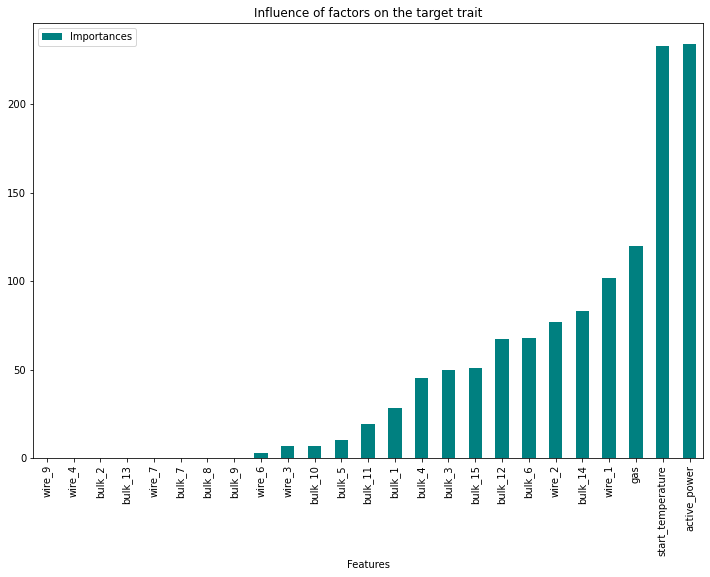

In [48]:
importances = model.feature_importances_
final_df = pd.DataFrame({"Features" : pd.DataFrame(features_train).columns, "Importances" : importances})

final_df = final_df.sort_values('Importances')


final_df.plot.bar(x = 'Features', color = 'teal', figsize=(12,8))
plt.title('Influence of factors on the target trait')

From the resulting histogram, it can be seen that the features bulk_2, bulk_13, bulk_7, bulk_8, bulk_9, wire_9, wire_4, wire_7 do not affect the model at all, which means they can be removed from the model, and not used by the business for further tasks.

# 4. Conclusion

To solve the problem posed by the metallurgical plant "Temper Steel", a model was built to predict the temperature of the steel. To accomplish this task, the following decisions were made:

* Data analysis was performed, anomalous values were determined, the necessary features for building a model were determined.
* Prepared data and features. All the necessary features are combined with the removal of anomalies and omissions, and an assessment of multicollinearity is made.
* 4 models trained with the best hyperparameters and one with the best MAE metric selected.
* The estimate of the best model (LGBMRegressor) on the test set is obtained

The MAE metric on the test sample turned out to be 5.82, which allows us to recommend this model for solving further business problems.

# 5. Report

## 5.1. The process of steel processing in the metallurgical plant  "Temper Steel"

When processing steel in the metallurgical plant "Temper Steel", there is a question of reducing energy costs in the process of steel production by the most accurate prediction of its temperature. The steelmaking process itself consists of several cycles of processing steel in a 100-ton metal ladle treated with refractory material and capable of withstanding high temperatures. The cycle consists of heating a metal mixture with graphite electrodes and measuring the initial temperature, after which sulfur is removed from the alloy, the chemical composition is measured, an inert gas is blown and bulk materials and wire are added to change its composition. All this directly affects the final temperature of the alloy. For some batch, several cycles of the process are sufficient, and for some batches, the number of cycles can be a multiple higher.

Understand the intricacies of the process, find the main factors that affect temperature and help businesses reduce energy costs with a model built on the basis of machine learning.

## 5.2. Dataset to Explore and Model.

To conduct the study, the plant proposed a set of data included in the production process. This set consists of 7 tables linked by batches of steel processing:

* Separately, a table with the parameters of the electrodes for each batch is highlighted, where active and reactive powers are highlighted with the heating time and disconnection of the electrodes in the cycle of each batch.
* The table of volumes of bulk materials is represented by 15 volumes of additives
* Table with time data for adding 15 volumes of bulk materials.
* Table with gas purge volumes for each batch
* Table with dates and temperature measurements for each cycle in batches
* Table with data on 9 amounts of additives of wire materials
* Table with time data for additions of 9 volumes of bulk materials

Each table must have a key - the batch number, which links the information provided to each other

## 5.3. Research process

Before building the model, each data set was studied separately, anomalous values were found, gaps were removed, the importance of adding a factor to the model was determined, after which the data were combined into a common feature table.

The electrode data table has 3214 batches and 14876 iterations included in these batches. There are no gaps in all signs. As a result of the analysis of statistical information, a large anomalous negative value of reactive power was revealed, which strongly affects the average and median. A lot where this value is present was excluded from the sample. Without this anomaly, there is a strong correlation between the values of active and reactive power. It was customary to leave the rest of the positive values that stand out from the general mass due to the possibility of the existence of such values in reality and in order to reduce the optimism of the model.

The table of volumes of bulk materials contains 3129 batches. For each batch, 15 volumes of bulk materials are presented, and each batch contains a different number of volumes, hence there are gaps in the features. In order not to lose the informativeness of the data, the gaps were filled with zeros.

The table with data on the time of adding bulk materials completely repeats the previous table in terms of the amount of data and gaps. When analyzing the time, it was found that in each batch part of the additives is introduced simultaneously, it is also worth noting that some of the time values for adding the additive are earlier than the first temperature measurement, which is incorrect for this task. In practice, it is worth deleting such batches, but due to limited data, we risk losing most of the values, which can lead to an increase in the optimism of the model. Based on this, it is customary not to use this table as features for building a model.

The table with gas purge volumes contains 3239 batches. The distribution of gas volumes varies widely. Decided not to remove outliers as they may exist in a business environment.

The table with dates and temperature measurements contains 3216 values, 15907 measurements. The "Temperature" feature contains gaps that have been removed. In these measurements, there are values below the passport melting temperature of steel, which indicates the presence of either another alloy, or incorrect measurements. All parties with such measurements were removed.

The table with data on the volume of additions of wire materials contains 3081 batches and 9 volumes. The main amount of additives in batches for the first and second volumes, hence there are gaps in the features. To avoid data loss, gaps are filled with zeros.

The table with data on the time of adding wire completely repeats the previous table in terms of the number of data and gaps. When analyzing the time, a similar situation was found with the time of adding bulk materials - some of the measurements take place earlier than the first temperature measurement. In order not to lose a large amount of data, it is customary not to use this table to build a model.

## 5.4. Data preparation process

During data preprocessing, all of the above gaps were filled with zeros, batches with no temperature were removed, a large reactive power anomaly was also removed, and temperatures below 1400 were also removed.

For each batch, the values of active and reactive power were summed up. The values of the first and last temperature measurements were highlighted, and the values with the same measurement time were also deleted.

Further, all the features necessary for creating the model were combined - prepared data from temperature measurements and total active and reactive powers, volumes of bulk materials, wire and gases.

In the resulting feature table, the data types were replaced from float to int. The features were checked for multicollinearity; as a result of the analysis of the resulting graph, one of the two features with correlation values > 0.9 was removed: reactive power, 8 the volume of wire materials. Also removed volume 5 wire materials due to missing any values.

## 5.5. Model training and testing

After completion of the analysis and data preprocessing, the target feature (final temperature) was separated from the rest. The features are divided into training and test samples in a ratio of 4:1. In order for the output model to receive predictions in the form of real numbers (temperature values), it is necessary to solve the regression problem. The following models suitable for this stage of training were chosen:

* LinearRegression;
* DecisionTreeRegressor;
* LGBMRegressor;
* XGBRegressor

The Mean Absolute Error (MAE) metric is most appropriate for evaluating models.

The written hyperparameter selection function made it possible to obtain the necessary values for each model. These models with final hyperparameters were trained on cross-validation. The best models in terms of the MAE metric on the training set were LGBMRegressor and XGBRegressor with almost the same values.

As a result, the LGBMRegressor model was tested, which was able to reach the MAE metric - 5.82.

As a result, a graph of the influence of factors on temperature was constructed. As a result, it turned out that the features bulk_2, bulk_13, bulk_7, bulk_8, bulk_9, wire_9, wire_4, wire_7 do not affect the model at all, which means that they can be removed from the model, and business should not be taken into account when solving this problem.

## 5.6. Results

The model obtained in the course of solving the problem can be used to determine the final temperature of the alloy. However, the mill should pay attention to the initial temperature of the alloy, since this factor greatly affects the target trait. If the business manages to control this parameter through other factors, then it will be possible to reduce energy costs.

All points of the original plan were completed in the report. As such, there were no difficulties in solving this problem; good data processing and preparation and selection of hyperparameters made it possible to achieve a satisfying MAE metric.